In [ ]:
!pip uninstall -y jpype1
!pip install --upgrade --quiet pip setuptools wheel
!pip install --quiet --no-cache-dir --only-binary :all: jpype1==1.5.0 konlpy==0.6.0

import sys, jpype
print("Python:", sys.version)
print("JPype1:", jpype.__version__)

Found existing installation: JPype1 1.5.0
Uninstalling JPype1-1.5.0:
  Successfully uninstalled JPype1-1.5.0
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
JPype1: 1.5.0


In [ ]:
!apt-get update -qq
!apt-get install -y openjdk-8-jdk-headless -qq
!pip install --quiet jpype1==1.4.0 konlpy==0.6.0 pandas==2.2.2 tqdm==4.66.4

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["JAVA_TOOL_OPTIONS"] = "-Xms512m -Xmx2g"

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for jpype1 (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> No available output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for jpype1
error: failed-wheel-build-for-install

× Failed to build installable wheels for some pyproject.toml based projects
╰─> jpype1


In [ ]:
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH_KBS    = '/content/drive/MyDrive/공통 시각화/kbs_domestic_violence_with_year.csv'
PATH_JTBC   = '/content/drive/MyDrive/공통 시각화/jtbc_domestic_violence_with_year.csv'
PATH_YONHAP = '/content/drive/MyDrive/공통 시각화/yonhap_domestic_violence_with_year.csv'

In [ ]:
def check_exist(path):
    ok = os.path.exists(path)
    print(f'· 파일 존재 확인: {path} -> {ok}')
    return ok

def peek_df(df, name, n=3):
    print(f'\n[{name}] 미리보기 (상위 {n}행) | shape={df.shape}')
    display(df.head(n))
    print(f'[{name}] 컬럼: {list(df.columns)}')

def nonempty_rate(series):
    s = series.fillna('').astype(str).str.strip()
    return (s.ne('')).mean()

def print_rule(msg):
    print('-' * 80)
    print(msg)
    print('-' * 80)

In [ ]:
CANDIDATE_TEXT_COLS  = ['content','text','body','article','본문','기사본문',
                        'clean_text','text_for_model','contents','document']
CANDIDATE_TITLE_COLS = ['title','제목']
CANDIDATE_MEDIA_COLS = ['언론사','media','press','신문사','매체']

def pick_first_exist(cols, candidates):
    cols_lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand in cols:
            return cand
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

def load_one(path, media_label=None):
    print_rule(f'로드 시작: {path}')
    assert check_exist(path), f'파일이 없습니다: {path}'
    df = pd.read_csv(path)
    peek_df(df, f'원본({os.path.basename(path)})')

    # 언론사 컬럼
    media_col = pick_first_exist(df.columns, CANDIDATE_MEDIA_COLS)
    if media_col is None:
        df['언론사'] = media_label if media_label else os.path.basename(path).split('_')[0].upper()
        print(f'· 언론사 컬럼 자동 생성 -> "{df["언론사"].iloc[0]}" 로 라벨링(최초값 기준)')
    else:
        print(f'· 언론사 컬럼 자동 인식: "{media_col}"')
        df['언론사'] = df[media_col].astype(str)
        print('· 언론사 고유값:', df['언론사'].unique()[:10])

    text_col  = pick_first_exist(df.columns, CANDIDATE_TEXT_COLS)
    title_col = pick_first_exist(df.columns, CANDIDATE_TITLE_COLS)
    print(f'· 텍스트 후보 인식 -> text_col={text_col}, title_col={title_col}')

    if text_col is None and title_col is None:
        print('[경고] 본문/제목 컬럼이 없어 빈 텍스트로 대체됩니다.')
        df['__text__'] = ''
    elif text_col is None:
        df['__text__'] = df[title_col].fillna('').astype(str)
        print('· 본문 없음 → 제목만 사용하여 __text__ 생성')
    elif title_col is None:
        df['__text__'] = df[text_col].fillna('').astype(str)
        print('· 제목 없음 → 본문만 사용하여 __text__ 생성')
    else:
        df['__text__'] = (df[title_col].fillna('') + ' ' + df[text_col].fillna('')).astype(str)
        print('· 제목+본문 결합 → __text__ 생성')

    rate = nonempty_rate(df['__text__'])
    print(f'· __text__ 비공백 비율: {rate:.2%}  (권장: 60% 이상)')
    empty_cnt = (df["__text__"].str.strip()=='').sum()
    print(f'· 완전공백 행 수: {empty_cnt} / {len(df)}')

    out = df[['언론사','__text__']].copy()
    peek_df(out, f'정리({os.path.basename(path)})')
    return out

In [ ]:
kbs    = load_one(PATH_KBS,    'KBS')
jtbc   = load_one(PATH_JTBC,   'JTBC')
yonhap = load_one(PATH_YONHAP, '연합뉴스')

df = pd.concat([kbs, jtbc, yonhap], ignore_index=True)
print_rule('세 파일 결합 완료')
peek_df(df, '통합 DF', n=5)

--------------------------------------------------------------------------------
로드 시작: /content/drive/MyDrive/공통 시각화/kbs_domestic_violence_with_year.csv
--------------------------------------------------------------------------------
· 파일 존재 확인: /content/drive/MyDrive/공통 시각화/kbs_domestic_violence_with_year.csv -> True

[원본(kbs_domestic_violence_with_year.csv)] 미리보기 (상위 3행) | shape=(352, 19)


,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,8.100101e+06,20250918,KBS,이유진,끊이지 않는 가정폭력 “집안 문제 아니다”,사회>사건_사고,사회>여성,사회>미디어,범죄>범죄일반>폭행,범죄>범죄일반>살인,NaN,NaN,강원도,"경기대학교,경찰,춘천","가정폭력,집안,앵커,강원도,사건,가정,폭력,신고,접수,집안,대책,지적,이유진,보도,...","피해자,강원도,가정폭력,이유진,음성변조,20건,춘천,가족끼리,경기대학교,편의점,검은...",[KBS 춘천]\n [앵커]\n\n 강원도에서도 가정 폭력 사건이 끊이지 않고 있습...,https://news.kbs.co.kr/news/view.do?ncd=836176...,NaN
1,8.100101e+06,20250918,KBS,이유진,끊이지 않는 가정폭력 “집안 문제 아니다”,사회>사건_사고,사회>여성,사회>미디어,범죄>범죄일반>폭행,범죄>범죄일반>살인,NaN,NaN,강원도,"경기대학교,경찰,춘천","가정폭력,집안,앵커,강원도,사건,가정,폭력,신고,접수,집안,대책,지적,이유진,보도,...","피해자,강원도,가정폭력,이유진,음성변조,20건,춘천,가족끼리,경기대학교,편의점,검은...",[KBS 춘천]\n [앵커]\n\n 강원도에서도 가정 폭력 사건이 끊이지 않고 있습...,https://news.kbs.co.kr/news/view.do?ncd=836149...,중복
2,8.100101e+06,20250916,KBS,KBS,“스토킹 교제 폭력 피해 지원 예산 28.6억↑”,사회>여성,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"정부,여성가족부","스토킹,교제,28.6,폭력,피해,지원,예산,28.6,정부,스토킹,피해자,교제,폭력,...","피해자,내년도,여성가족부,가족부,주거지원,453억,지원,폭력,증액,서비스,스토킹,예...",정부가 스토킹과 교제 폭력 피해자에 대한 지원 예산을 늘렸습니다.\n\n여성가족부는...,https://news.kbs.co.kr/news/view.do?ncd=835889...,NaN


[원본(kbs_domestic_violence_with_year.csv)] 컬럼: ['뉴스 식별자', '일자', '언론사', '기고자', '제목', '통합 분류1', '통합 분류2', '통합 분류3', '사건/사고 분류1', '사건/사고 분류2', '사건/사고 분류3', '인물', '위치', '기관', '키워드', '특성추출(가중치순 상위 50개)', '본문', 'URL', '분석제외 여부']
· 언론사 컬럼 자동 인식: "언론사"
· 언론사 고유값: ['KBS']
· 텍스트 후보 인식 -> text_col=본문, title_col=제목
· 제목+본문 결합 → __text__ 생성
· __text__ 비공백 비율: 100.00%  (권장: 60% 이상)
· 완전공백 행 수: 0 / 352

[정리(kbs_domestic_violence_with_year.csv)] 미리보기 (상위 3행) | shape=(352, 2)


,언론사,__text__
0,KBS,끊이지 않는 가정폭력 “집안 문제 아니다” [KBS 춘천]\n [앵커]\n\n 강원...
1,KBS,끊이지 않는 가정폭력 “집안 문제 아니다” [KBS 춘천]\n [앵커]\n\n 강원...
2,KBS,“스토킹 교제 폭력 피해 지원 예산 28.6억↑” 정부가 스토킹과 교제 폭력 피해자...


[정리(kbs_domestic_violence_with_year.csv)] 컬럼: ['언론사', '__text__']
--------------------------------------------------------------------------------
로드 시작: /content/drive/MyDrive/공통 시각화/jtbc_domestic_violence_with_year.csv
--------------------------------------------------------------------------------
· 파일 존재 확인: /content/drive/MyDrive/공통 시각화/jtbc_domestic_violence_with_year.csv -> True

[원본(jtbc_domestic_violence_with_year.csv)] 미리보기 (상위 3행) | shape=(69, 5)


,year,press,title,content,url
0,NaN,JTBC,‘30년 가정폭력’ 끝에 아버지 살해한 아들…징역 6년 선고,‘30년 가정폭력’ 끝에 아버지 살해한 아들…징역 6년 선고 공지사항 더 보기 맨 위로,https://news.jtbc.co.kr/article/NB12246074?inf...
1,NaN,JTBC,가정폭력 신고 현장서 ‘흉기 난동’…출동 경찰관 3명 피습,가정폭력 신고 현장서 ‘흉기 난동’…출동 경찰관 3명 피습 공지사항 더 보기 맨 위로,https://news.jtbc.co.kr/article/NB12247576?inf...
2,NaN,JTBC,가정폭력 신고 현장서 40대 남성 칼부림…경찰관 3명 다쳐,가정폭력 신고 현장서 40대 남성 칼부림…경찰관 3명 다쳐 공지사항 더 보기 맨 위로,https://news.jtbc.co.kr/article/NB12247573?inf...


[원본(jtbc_domestic_violence_with_year.csv)] 컬럼: ['year', 'press', 'title', 'content', 'url']
· 언론사 컬럼 자동 인식: "press"
· 언론사 고유값: ['JTBC']
· 텍스트 후보 인식 -> text_col=content, title_col=title
· 제목+본문 결합 → __text__ 생성
· __text__ 비공백 비율: 100.00%  (권장: 60% 이상)
· 완전공백 행 수: 0 / 69

[정리(jtbc_domestic_violence_with_year.csv)] 미리보기 (상위 3행) | shape=(69, 2)


,언론사,__text__
0,JTBC,‘30년 가정폭력’ 끝에 아버지 살해한 아들…징역 6년 선고 ‘30년 가정폭력’ 끝...
1,JTBC,가정폭력 신고 현장서 ‘흉기 난동’…출동 경찰관 3명 피습 가정폭력 신고 현장서 ‘...
2,JTBC,가정폭력 신고 현장서 40대 남성 칼부림…경찰관 3명 다쳐 가정폭력 신고 현장서 4...


[정리(jtbc_domestic_violence_with_year.csv)] 컬럼: ['언론사', '__text__']
--------------------------------------------------------------------------------
로드 시작: /content/drive/MyDrive/공통 시각화/yonhap_domestic_violence_with_year.csv
--------------------------------------------------------------------------------
· 파일 존재 확인: /content/drive/MyDrive/공통 시각화/yonhap_domestic_violence_with_year.csv -> True

[원본(yonhap_domestic_violence_with_year.csv)] 미리보기 (상위 3행) | shape=(369, 5)


,year,press,title,content,url
0,2025.0,연합뉴스,"올해 살인범죄 388건 중 70건, 가정폭력·교제폭력·스토킹 전력",경찰청은 올해 1∼7월 살인범죄(미수 포함) 사건 388건을 전수조사해 과거 신고 ...,https://www.yna.co.kr/view/AKR2025082507420000...
1,2025.0,연합뉴스,"프로야구 선수 출신 부산 조폭, 가정폭력 혐의 구속영장",부산경찰청 형사기동대는 가정폭력 범죄의 처벌 등에 관한 특례법 위반 혐의로 A씨 구...,https://www.yna.co.kr/view/AKR2025090812420005...
2,2025.0,연합뉴스,"40대 배우, 자택서 아내 폭행으로 가정폭력 신고당해",14일 경찰에 따르면 지난달 24일 오후 경기도 부천시 자택에서 40대 배우 A씨가...,https://www.yna.co.kr/view/AKR2025081409440006...


[원본(yonhap_domestic_violence_with_year.csv)] 컬럼: ['year', 'press', 'title', 'content', 'url']
· 언론사 컬럼 자동 인식: "press"
· 언론사 고유값: ['연합뉴스']
· 텍스트 후보 인식 -> text_col=content, title_col=title
· 제목+본문 결합 → __text__ 생성
· __text__ 비공백 비율: 100.00%  (권장: 60% 이상)
· 완전공백 행 수: 0 / 369

[정리(yonhap_domestic_violence_with_year.csv)] 미리보기 (상위 3행) | shape=(369, 2)


,언론사,__text__
0,연합뉴스,"올해 살인범죄 388건 중 70건, 가정폭력·교제폭력·스토킹 전력 경찰청은 올해 1..."
1,연합뉴스,"프로야구 선수 출신 부산 조폭, 가정폭력 혐의 구속영장 부산경찰청 형사기동대는 가정..."
2,연합뉴스,"40대 배우, 자택서 아내 폭행으로 가정폭력 신고당해 14일 경찰에 따르면 지난달 ..."


[정리(yonhap_domestic_violence_with_year.csv)] 컬럼: ['언론사', '__text__']
--------------------------------------------------------------------------------
세 파일 결합 완료
--------------------------------------------------------------------------------

[통합 DF] 미리보기 (상위 5행) | shape=(790, 2)


,언론사,__text__
0,KBS,끊이지 않는 가정폭력 “집안 문제 아니다” [KBS 춘천]\n [앵커]\n\n 강원...
1,KBS,끊이지 않는 가정폭력 “집안 문제 아니다” [KBS 춘천]\n [앵커]\n\n 강원...
2,KBS,“스토킹 교제 폭력 피해 지원 예산 28.6억↑” 정부가 스토킹과 교제 폭력 피해자...
3,KBS,‘관계성 범죄’ 가해자 막는다 “접근금지 자동신고 앱 개발” [앵커]\n\n 끊이지...
4,KBS,‘관계성 범죄’ 가해자 막는다 “접근금지 자동신고 앱 개발” [앵커]\n\n 끊이지...


[통합 DF] 컬럼: ['언론사', '__text__']


In [ ]:
import re, pandas as pd

TEXT_CANDIDATES = ['content','text','body','article','본문','text_for_model','clean_text','document','contents']
UI_NOISE = set('공지사항 보기 위로 기사입력 전체메뉴 구독 로그인 회원가입 댓글 공유 링크 바로가기 바로 가기 더보기 탑 메뉴 닫기'.split())

def choose_best_text_column(df: pd.DataFrame):
    cols = [c for c in TEXT_CANDIDATES if c in df.columns]
    if not cols: return None
    scores = []
    for c in cols:
        s = ' '.join(df[c].dropna().astype(str).head(200))
        toks = re.findall(r'[가-힣]{2,}', s)
        ui_cnt = sum(t in UI_NOISE for t in toks)
        scores.append((ui_cnt/ max(len(toks),1), c))
    scores.sort()
    return scores[0][1]

In [ ]:
def load_df(path, label):
    df = pd.read_csv(path)
    mcol = next((c for c in ['언론사','media','press','신문사','매체'] if c in df.columns), None)
    df['언론사'] = df[mcol].astype(str) if mcol else label

    tcol = next((c for c in ['title','제목'] if c in df.columns), None)
    bcol = choose_best_text_column(df)

    if bcol and tcol: df['__text__'] = (df[tcol].fillna('') + ' ' + df[bcol].fillna('')).astype(str)
    elif bcol:        df['__text__'] = df[bcol].fillna('').astype(str)
    elif tcol:        df['__text__'] = df[tcol].fillna('').astype(str)
    else:             df['__text__'] = ''
    return df[['언론사','__text__']]

In [ ]:
import re
RE_KO = re.compile(r'[가-힣]{2,}')

BAD_SUBSTR = [
    '공지사항','보기','위로','기사입력','속보','단독','앵커','리포트','영상','기자',
    '밝혔','전했','말했','있습니다','했습니다','되었습니다','되고','하며',
    '관련','대한','동안','최근','오늘','어제','지난','지난해','올해',
    '했다','현장서','추석','제주','부산','대전'
]
BAD_SUBSTR_RE = re.compile('|'.join(map(re.escape, BAD_SUBSTR)))

JOSA_RE = re.compile(r'(은|는|이|가|을|를|의|와|과|도|만|에|에서|에게|께서|까지|부터|로|으로)$')
Sshi_RE = re.compile(r'씨(는|가|를|를|의|가)?$')

STOP_EXACT = set('있다 있다가 있는 해당 위해 위해서 경우 당시 함께 등을 위주 등 등의 때문 이후 이전 최근 동안 연휴 올해 지난해 오늘 어제 내일 년을 년간 차례 건수 관련 지원 위해 위해서로'.split())

GEO_STOP = set('서울 경기 인천 부산 대구 대전 광주 울산 세종 제주 강원 충북 충남 전북 전남 경북 경남'.split())

def normalize_token(w: str):
    w = JOSA_RE.sub('', w)       # 조사 제거
    w = Sshi_RE.sub('', w)       # 씨+조사 제거
    return w

def bad_token(w: str) -> bool:
    if BAD_SUBSTR_RE.search(w): return True
    if w in STOP_EXACT:         return True
    if re.fullmatch(r'\d+년|\d+월|\d+일|\d+시', w): return True
    return False

def tokenize(text: str):
    toks = []
    for w in RE_KO.findall(text):
        w = normalize_token(w)
        if len(w) < 2:       continue
        if bad_token(w):     continue
        toks.append(w)
    return toks

from collections import Counter
media_texts = df.groupby('언론사')['__text__'].apply(lambda s: ' '.join(s))
media_freqs  = {m: Counter(tokenize(t)) for m,t in media_texts.items()}

for media, freqs in media_freqs.items():
    print(f'\n[{media}] 상위 20 키워드')
    top20 = pd.DataFrame(freqs.most_common(20), columns=["키워드","빈도"])
    top20.index = range(1, len(top20) + 1)
    display(top20)


[JTBC] 상위 20 키워드


,키워드,빈도
1,아내,38
2,가정폭력,28
3,남편,20
4,살해한,16
5,아들,14
6,신고,14
7,살해,14
8,폭력,12
9,흉기,10
10,남성,10



[KBS] 상위 20 키워드


,키워드,빈도
1,가정폭력,374
2,경찰,176
3,신고,161
4,범죄,148
5,피해자,137
6,남성,89
7,여성,89
8,가정,70
9,사건,68
10,폭력,58



[연합뉴스] 상위 20 키워드


,키워드,빈도
1,경찰,636
2,혐의,600
3,가정폭력,510
4,피해자,456
5,아내,436
6,범행,394
7,징역,297
8,신고,288
9,사건,278
10,흉기,251


In [ ]:
!apt-get -y update > /dev/null
!apt-get -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
plt.rc('font', family='NanumGothic')

print("폰트 경로:", font_path)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
폰트 경로: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


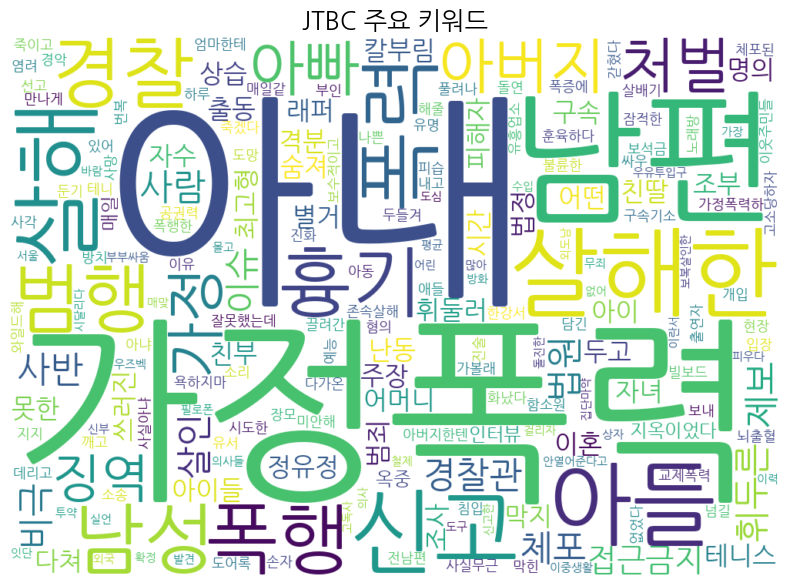

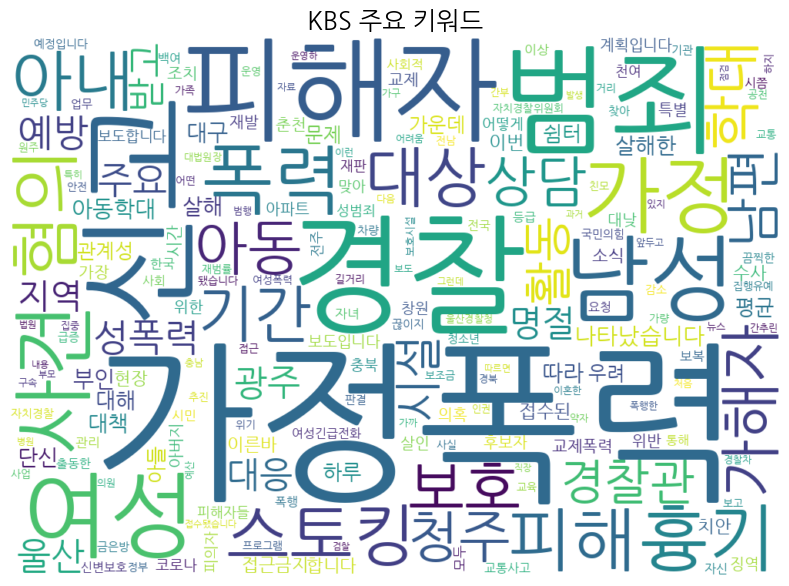

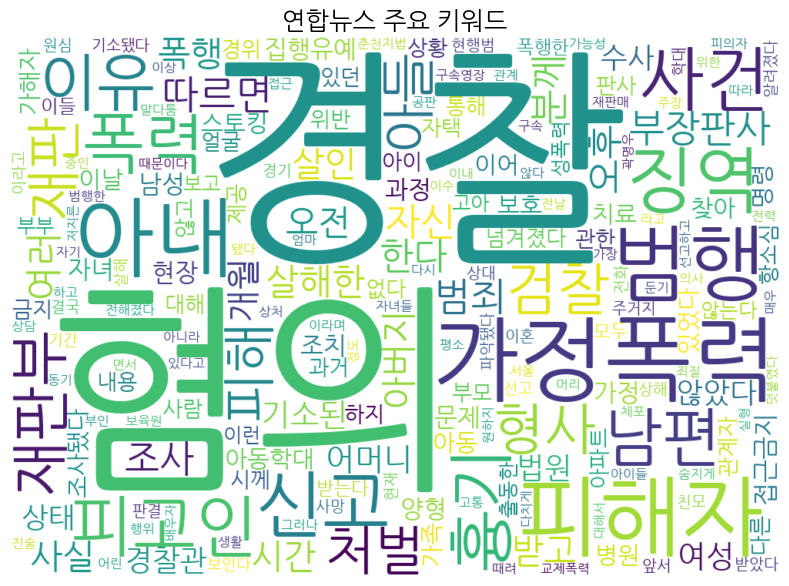

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for media, freqs in media_freqs.items():
    if not freqs:
        continue

    wc = WordCloud(
        font_path=font_path,
        background_color='white',
        width=1000,
        height=700
    ).generate_from_frequencies(dict(freqs.most_common(400)))

    plt.figure(figsize=(10,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{media} 주요 키워드', fontsize=18)
    plt.show()

In [ ]:
summary_tables = {}
for media, freqs in media_freqs.items():
    print(f'\n[{media}] 상위 20 키워드')
    top20 = pd.DataFrame(freqs.most_common(20), columns=["키워드","빈도"])
    top20.index = range(1, len(top20) + 1)
    display(top20)


[JTBC] 상위 20 키워드


,키워드,빈도
1,아내,38
2,가정폭력,28
3,남편,20
4,살해한,16
5,아들,14
6,신고,14
7,살해,14
8,폭력,12
9,흉기,10
10,남성,10



[KBS] 상위 20 키워드


,키워드,빈도
1,가정폭력,374
2,경찰,176
3,신고,161
4,범죄,148
5,피해자,137
6,남성,89
7,여성,89
8,가정,70
9,사건,68
10,폭력,58



[연합뉴스] 상위 20 키워드


,키워드,빈도
1,경찰,636
2,혐의,600
3,가정폭력,510
4,피해자,456
5,아내,436
6,범행,394
7,징역,297
8,신고,288
9,사건,278
10,흉기,251
